In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
# Load the datasets
transactions_df = pd.read_csv('../data/updated_fraud_transactions.csv')
customers_df = pd.read_csv('../data/customer_dataset 1.csv')

# Display the first few rows of each dataset
print(transactions_df.head())
print(customers_df.head())

  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  
0     In  4887.67          B0004      0  
1     In  2371.33         B00010      0  
2     In  4733.44          B0008      0  
3     In  1544.12          B0005      0  
4    Out  3978.04          B0004      0  
   Customer ID                Name  Age      Location  Gender Account Type  \
0        10001      Nimal Fernando   61        Jaffna  Female      Savings   
1        10002  Sunil Samarasinghe   60        Jaffna   Other      Current   
2        10003    Ruwan Jayasinghe   67         Gal

Transaction ID       0
Timestamp            0
Sender Account ID    0
Transaction Type     0
IN_OUT               0
Amount               0
Recipient Bank       0
Fraud                0
dtype: int64
Customer ID     0
Name            0
Age             0
Location        0
Gender          0
Account Type    0
Device Count    0
dtype: int64
       Sender Account ID         Amount          Fraud
count      100000.000000  100000.000000  100000.000000
mean        10050.554500    2619.425362       0.048530
std            28.890176    2051.210808       0.214884
min         10001.000000       2.468396       0.000000
25%         10026.000000    1205.750000       0.000000
50%         10051.000000    2481.825000       0.000000
75%         10076.000000    3776.750000       0.000000
max         10100.000000   23017.641096       1.000000
        Customer ID         Age  Device Count
count    100.000000  100.000000    100.000000
mean   10050.500000   51.030000      4.650000
std       29.011492   17.536948

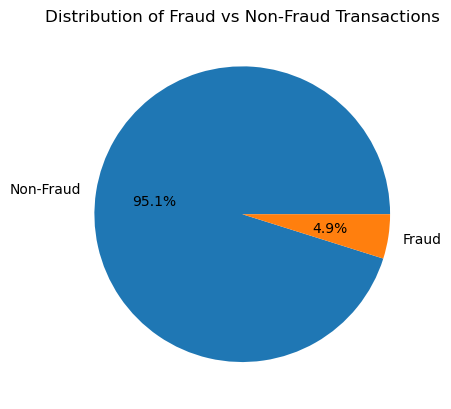

In [3]:

# Check for missing values
print(transactions_df.isnull().sum())
print(customers_df.isnull().sum())

# Display basic statistics
print(transactions_df.describe())
print(customers_df.describe())

# Check the distribution of fraud vs non-fraud transactions
fraud_count = transactions_df['Fraud'].value_counts()
print(fraud_count)
plt.pie(fraud_count, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

# Convert timestamp to datetime
transactions_df['Timestamp'] = pd.to_datetime(transactions_df['Timestamp'])

# Extract time-based features
transactions_df['Hour'] = transactions_df['Timestamp'].dt.hour
transactions_df['Day'] = transactions_df['Timestamp'].dt.day
transactions_df['Month'] = transactions_df['Timestamp'].dt.month
transactions_df['DayOfWeek'] = transactions_df['Timestamp'].dt.dayofweek

# Encode categorical variables
transactions_df = pd.get_dummies(transactions_df, columns=['Transaction Type', 'IN_OUT', 'Recipient Bank'])
customers_df = pd.get_dummies(customers_df, columns=['Location', 'Gender', 'Account Type'])

In [4]:
# Merge transaction and customer data
merged_df = pd.merge(transactions_df, customers_df, left_on='Sender Account ID', right_on='Customer ID')

# Calculate transaction frequency for each customer
transaction_frequency = merged_df.groupby('Customer ID')['Transaction ID'].count().reset_index()
transaction_frequency.columns = ['Customer ID', 'Transaction_Frequency']
merged_df = pd.merge(merged_df, transaction_frequency, on='Customer ID')

# Calculate average transaction amount for each customer
avg_transaction_amount = merged_df.groupby('Customer ID')['Amount'].mean().reset_index()
avg_transaction_amount.columns = ['Customer ID', 'Avg_Transaction_Amount']
merged_df = pd.merge(merged_df, avg_transaction_amount, on='Customer ID')

# Create a feature for transaction amount relative to customer's average
merged_df['Amount_Relative_To_Average'] = merged_df['Amount'] / merged_df['Avg_Transaction_Amount']

# Drop unnecessary columns
merged_df = merged_df.drop(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Customer ID', 'Name'], axis=1)

In [5]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = merged_df.drop('Fraud', axis=1)
y = merged_df['Fraud']

In [6]:
# 6. Data Balancing
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_balanced, y_balanced = rus.fit_resample(*smote.fit_resample(X, y))


In [7]:
print("Original dataset shape:", X.shape)
print("Balanced dataset shape:", X_balanced.shape)
print("\nOriginal class distribution:")
print(y.value_counts(normalize=True))
print("\nBalanced class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))


Original dataset shape: (100000, 42)
Balanced dataset shape: (115534, 42)

Original class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64

Balanced class distribution:
Fraud
0    0.588234
1    0.411766
Name: proportion, dtype: float64


In [8]:
# 7. Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [9]:
# 8. Feature Scaling / Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
print("Shape of training set:", X_train_scaled.shape)
print("Shape of validation set:", X_val_scaled.shape)
print("Shape of test set:", X_test_scaled.shape)
print("Distribution of target variable in training set:\n", pd.Series(y_train).value_counts(normalize=True))


Shape of training set: (80873, 42)
Shape of validation set: (17330, 42)
Shape of test set: (17331, 42)
Distribution of target variable in training set:
 Fraud
0    0.588231
1    0.411769
Name: proportion, dtype: float64


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build the model
model = build_model(X_train_scaled.shape[1])

# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val),
                    verbose=1)

Epoch 1/50


2024-10-15 09:37:37.862238: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2528/2528 [==============================] - 2s 732us/step - loss: 0.1431 - accuracy: 0.9391 - val_loss: 0.0758 - val_accuracy: 0.9683
Epoch 2/50
2528/2528 [==============================] - 1s 592us/step - loss: 0.0817 - accuracy: 0.9656 - val_loss: 0.0680 - val_accuracy: 0.9707
Epoch 3/50
2528/2528 [==============================] - 1s 580us/step - loss: 0.0740 - accuracy: 0.9682 - val_loss: 0.0653 - val_accuracy: 0.9710
Epoch 4/50
2528/2528 [==============================] - 1s 585us/step - loss: 0.0696 - accuracy: 0.9693 - val_loss: 0.0617 - val_accuracy: 0.9727
Epoch 5/50
2528/2528 [==============================] - 1s 585us/step - loss: 0.0666 - accuracy: 0.9696 - val_loss: 0.0589 - val_accuracy: 0.9727
Epoch 6/50
2528/2528 [==============================] - 2s 599us/step - loss: 0.0645 - accuracy: 0.9703 - val_loss: 0.0577 - val_accuracy: 0.9729
Epoch 7/50
2528/2528 [==============================] - 2s 640us/step - loss: 0.0629 - accuracy: 0.9713 - val_loss: 0.0566 - val_accura

542/542 [==============================] - 0s 313us/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10195
           1       0.98      0.96      0.97      7136

    accuracy                           0.98     17331
   macro avg       0.98      0.97      0.97     17331
weighted avg       0.98      0.98      0.98     17331



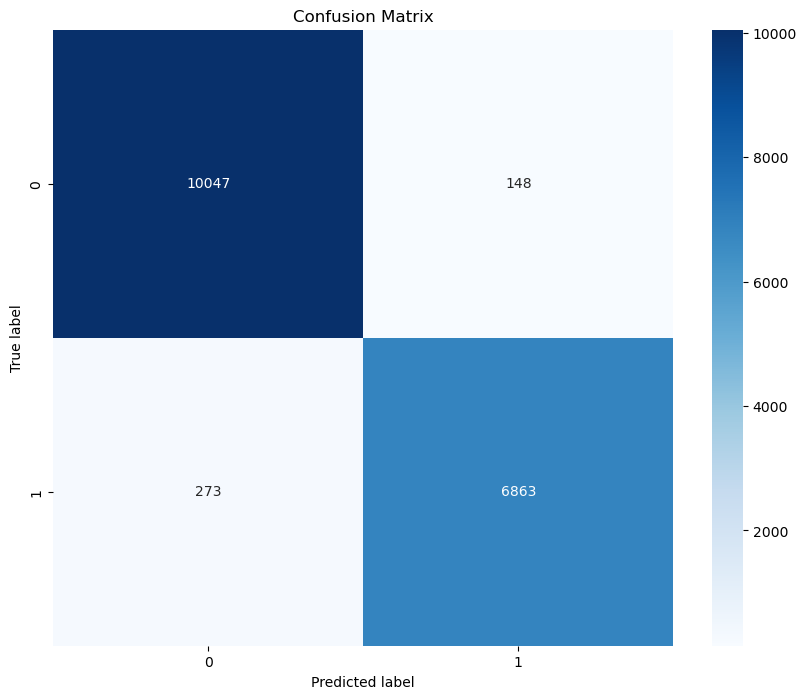

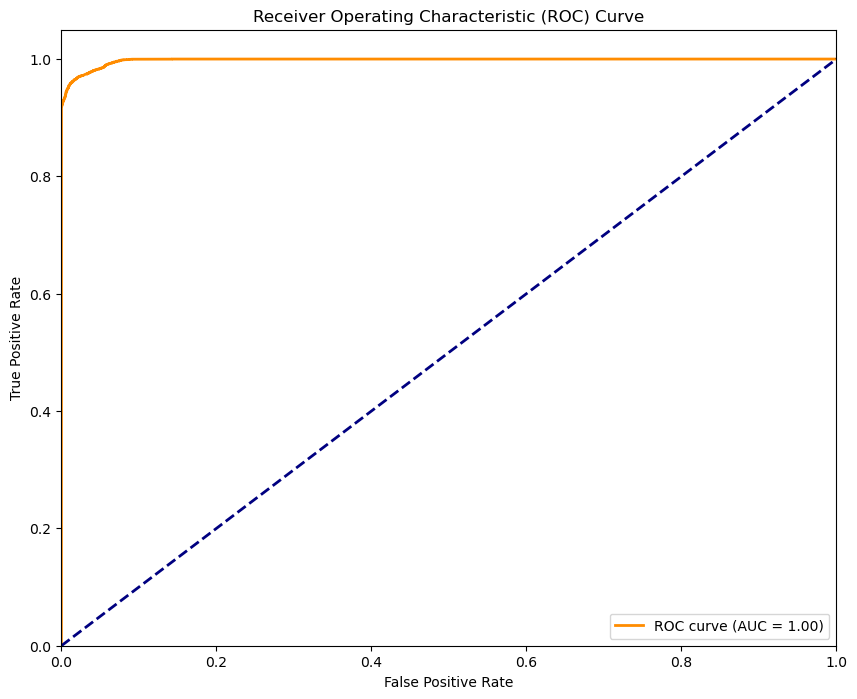

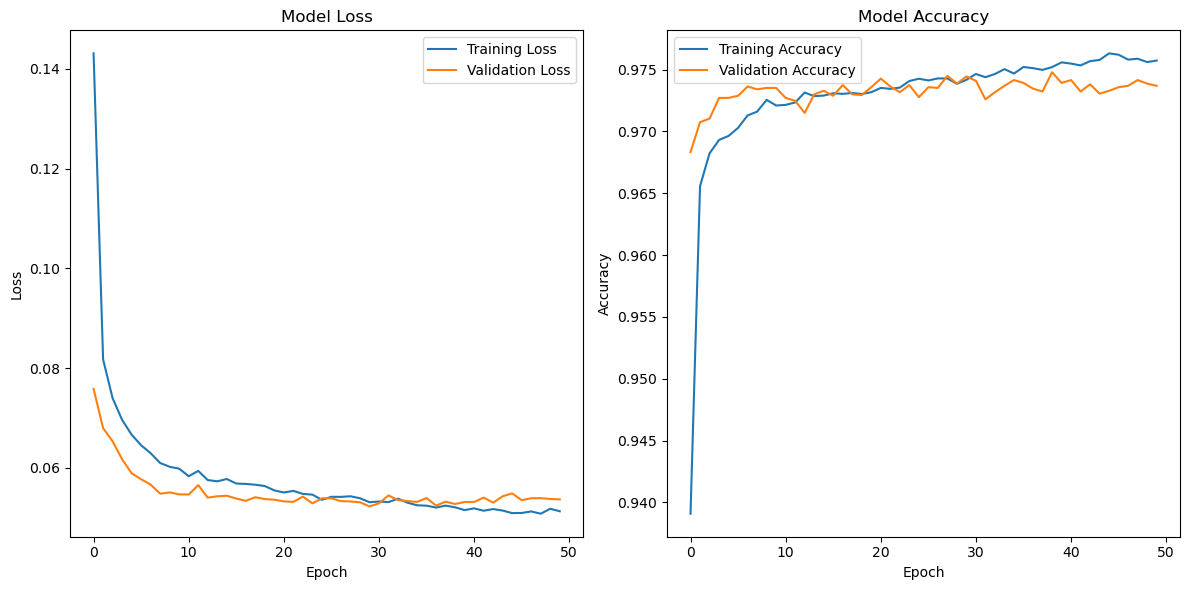

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

542/542 [==============================] - 0s 313us/step
Validation Set Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10194
           1       0.98      0.96      0.97      7136

    accuracy                           0.97     17330
   macro avg       0.97      0.97      0.97     17330
weighted avg       0.97      0.97      0.97     17330



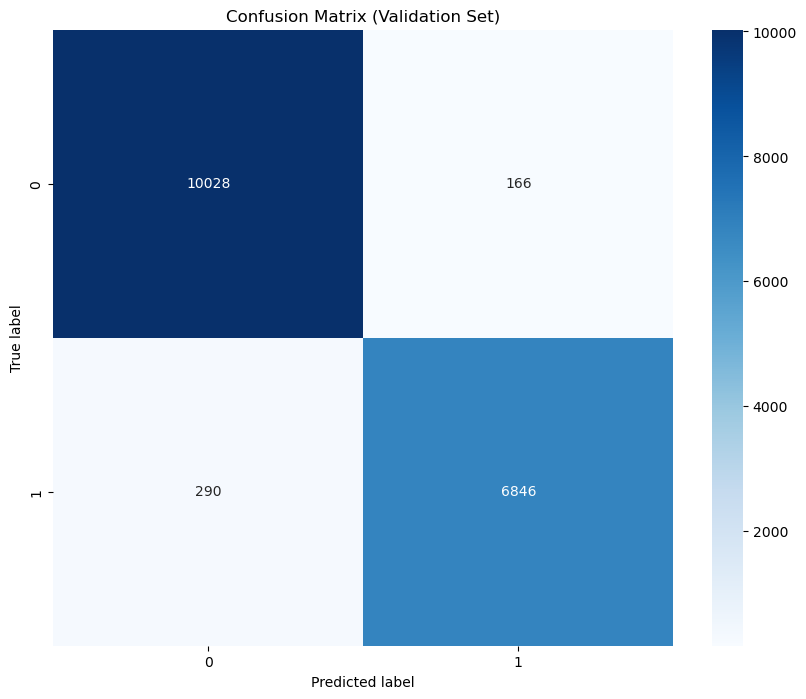

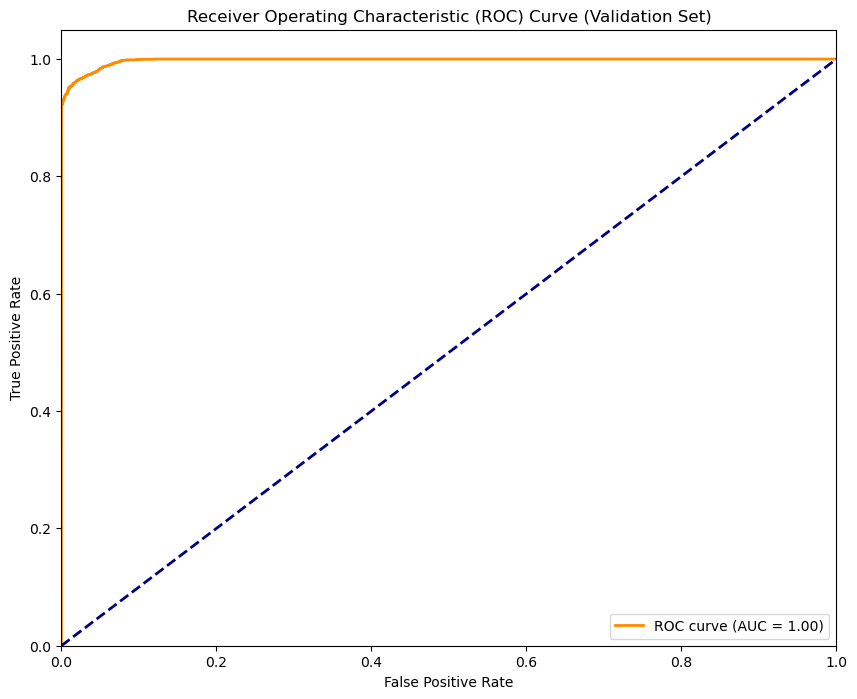

In [14]:
# Make predictions on validation set
y_val_pred = model.predict(X_val_scaled)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)

# Print classification report for validation set
print("Validation Set Results:")
print(classification_report(y_val, y_val_pred_classes))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC curve for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(10, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Validation Set)')
plt.legend(loc="lower right")
plt.show()

In [17]:
import keras_tuner as kt

def build_model_tuning(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=256, step=32),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model_tuning,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='fraud_detection'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
final_history = final_model.fit(
    X_train_scaled, y_train,
    epochs=100,  # Increase epochs for final training
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)



Trial 90 Complete [00h 08m 08s]
val_accuracy: 0.9627549648284912

Best val_accuracy So Far: 0.9685683250427246
Total elapsed time: 02h 18m 46s

The hyperparameter search is complete. The optimal number of layers: 3
The optimal learning rate for the optimizer is: 0.0002

Epoch 1/50
3806/3806 [==============================] - 10s 2ms/step - loss: 0.1281 - accuracy: 0.9427 - val_loss: 0.1076 - val_accuracy: 0.9501
Epoch 2/50
3806/3806 [==============================] - 12s 3ms/step - loss: 0.1071 - accuracy: 0.9508 - val_loss: 0.1021 - val_accuracy: 0.9534
Epoch 3/50
3806/3806 [==============================] - 9s 2ms/step - loss: 0.1042 - accuracy: 0.9523 - val_loss: 0.1026 - val_accuracy: 0.9528
Epoch 4/50
3806/3806 [==============================] - 10s 3ms/step - loss: 0.1019 - accuracy: 0.9538 - val_loss: 0.1002 - val_accuracy: 0.9539
Epoch 5/50
3806/3806 [==============================] - 9s 2ms/step - loss: 0.1001 - accuracy: 0.9542 - val_loss: 0.0971 - val_accuracy: 0.9560
Epoch 

In [ ]:
# Evaluate the final model
final_loss, final_accuracy = final_model.evaluate(X_test_scaled, y_test)
print(f'Final Test Accuracy: {final_accuracy:.4f}')



In [ ]:
# Save the final model
final_model.save('fraud_detection_model.h6')

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
def predict_fraud(new_data):
    # Preprocess the new data (apply the same preprocessing steps as before)
    # This is a placeholder - you'll need to implement the actual preprocessing steps
    preprocessed_data = preprocess_new_data(new_data)
    
    # Scale the data
    scaled_data = scaler.transform(preprocessed_data)
    
    # Make predictions
    predictions = final_model.predict(scaled_data)
    
    return predictions



In [ ]:
# Example usage:
new_transactions = pd.read_csv('new_transactions.csv')
fraud_probabilities = predict_fraud(new_transactions)
print(fraud_probabilities)